In [1]:
import sys
sys.path.append("models/raster")
sys.path.append("models/vector")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import torch
import torch.nn as nn
from torch_geometric.data import Batch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from initialize_gnn import initialize_gnn
from cnn import CNN
from vit import ViT

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    multimodal_path = "../scratch/multimodal"
else:
    device = torch.device("cpu")
    # local path
    multimodal_path = "../data.nosync/multimodal"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [6]:
class BuildingMultimodalDataset(Dataset):
    def __init__(self, raster_path, vector_path, operators, transform=None):
        '''Stores the directory and filenames of the individual raster (.npz) and vector (.pt) files.'''
        # store the path to the raster and vector files
        self.raster_path = raster_path
        self.vector_path = vector_path

        # get filenames of the individual files, sort the filenames to make them line up
        self.raster_filenames = sorted(os.listdir(self.raster_path))
        self.vector_filenames = sorted(os.listdir(self.vector_path))

        # make sure that the samples line up
        assert len(self.raster_filenames) == len(self.vector_filenames)

        # store indices of the operators within operator_order for slicing in the __getitem__ method
        self.operators = sorted([operator_order.index(operator) for operator in operators if operator in operator_order])

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation.'''
        return len(self.raster_filenames)

    def __getitem__(self, index):
        '''Enables indexing, returns graph and raster representation and generalization operator as label.'''
        # load the raster sample associated with the given index
        raster_filename = self.raster_filenames[index]
        raster_sample_raw = np.load(os.path.join(self.raster_path, raster_filename))

        # extract the rasters
        focal_building_raster = raster_sample_raw["focal_building"]
        context_buildings_raster = raster_sample_raw["context_buildings"]
        roads_raster = raster_sample_raw["roads"]

        # stack the rasters to shape (3, n_pixels, n_pixels) and convert to tensor
        raster_sample = np.stack([focal_building_raster, context_buildings_raster, roads_raster], axis=0)
        raster_sample = torch.from_numpy(raster_sample).float()

        # load the vector sample associated with the given index
        vector_filename = self.vector_filenames[index]
        vector_sample = torch.load(os.path.join(self.vector_path, vector_filename))

        # extract the operators from the graph object
        operators = vector_sample.y[self.operators].unsqueeze(0)

        # reshape the operators associated with the graph
        vector_sample.y = vector_sample.y[self.operators].reshape(1, -1)

        return raster_sample, vector_sample, operators

In [7]:
# custom collate function to generate batches, as DataLoader cannot collate HeteroData objects by default
def collate_raster_vector(batch):
    # unzip the batch
    raster_samples, vector_samples, operators = zip(*batch)

    # stack / concatenate the raster samples and operators along the batch dimension
    raster_batch = torch.stack(raster_samples, dim=0)
    operators_batch = torch.cat(operators, dim=0)

    # batch the vector samples
    vector_batch = Batch.from_data_list(vector_samples)

    return raster_batch, vector_batch, operators_batch

### Model design

In [8]:
class ClassificationHeadMultimodal(nn.Module):
    def __init__(self, n_input_features, n_classes):
        super(ClassificationHeadMultimodal, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=n_input_features, out_features=16),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=16, out_features=n_classes)
        )

    def forward(self, x):
        return self.fc(x)

class MultimodalModel(nn.Module):
    def __init__(self, raster_model, vector_model, dummy_raster_sample, dummy_vector_sample, n_classes):
        super(MultimodalModel, self).__init__()
        self.raster_model = raster_model
        self.vector_model = vector_model
        
        # both models are already trained and only require gradient for multimodal classification head
        for param in self.raster_model.parameters():
            param.requires_grad = False
        for param in self.vector_model.parameters():
            param.requires_grad = False

        # remove classification heads
        self.raster_model.classification_heads = nn.Identity()
        self.vector_model.classification_heads = nn.Identity()

        # pass dummy raster and vector samples through the networks to determine the number of output features
        # when the classification heads are missing
        out_raster = self.raster_model(dummy_raster_sample.unsqueeze(0))
        out_vector = self.vector_model(dummy_vector_sample.x_dict, dummy_vector_sample.edge_index_dict)
        n_raster_features = out_raster.shape[1]
        n_vector_features = out_vector.shape[1]

        self.classification_heads = nn.ModuleList([ClassificationHeadMultimodal(n_input_features=n_raster_features + n_vector_features,
                                                                                n_classes=1) for _ in range(n_classes)])

    def forward(self, raster, graph):
        raster_output = self.raster_model(raster)
        vector_output = self.vector_model(graph.x_dict, graph.edge_index_dict)

        # concatenate along feature dimension
        x = torch.cat((raster_output, vector_output), dim=1)

        # apply each classification head and concatenate the results along the final dimension
        outputs = torch.cat([head(x).squeeze(-1).unsqueeze(1) for head in self.classification_heads], dim=1)
        
        return outputs

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f'''Multimodal Model with {self.get_n_parameters():,} parameters consisting of
        raster model with {raster_model.get_n_parameters():,} parameters and 
        vector model with {vector_model.get_n_parameters():,} parameters.'''

### Elimination model

In [9]:
# define path to training, validation and test data for both raster and vector
path_to_raster_training_data = "../data.nosync/raster/training_data/elimination/training"
path_to_vector_training_data = "../data.nosync/vector/training_data/elimination/training"
path_to_raster_validation_data = "../data.nosync/raster/training_data/elimination/validation"
path_to_vector_validation_data = "../data.nosync/vector/training_data/elimination/validation"
path_to_raster_test_data = "../data.nosync/raster/training_data/elimination/test"
path_to_vector_test_data = "../data.nosync/vector/training_data/elimination/test"

# define input parameters
elimination_operators = ["elimination"]
n_classes = len(elimination_operators)

batch_size = 16

# construct training DataLoader
training_set = BuildingMultimodalDataset(path_to_raster_training_data, path_to_vector_training_data, operators=elimination_operators)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True, collate_fn=collate_raster_vector)

# construct validation DataLoader (no shuffling)
validation_set = BuildingMultimodalDataset(path_to_raster_validation_data, path_to_vector_validation_data, operators=elimination_operators)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_raster_vector)

# construct test DataLoader (no shuffling)
test_set = BuildingMultimodalDataset(path_to_raster_test_data, path_to_vector_test_data, operators=elimination_operators)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_raster_vector)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
250 samples in the validation set.
250 samples in the test set.


In [10]:
# load the trained raster model
raster_model_path = "../data.nosync/raster/models/elimination"
#raster_model_name = "CNN_eli_attachRoadsTrue_2190433p_1000s_10ep_bs16.pth"
#raster_model = CNN(n_channels=3, n_classes=1)
raster_model_name = "ViT_eli_attachRoadsTrue_26820129p_1000s_10ep_bs16.pth"
raster_model = ViT(channels=3, num_classes=1)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name))
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()
    
# load the trained vector model
vector_model_path = "../data.nosync/vector/models/elimination"
#vector_model_name = "HGNN_eli_attachRoadsTrue_253313p_1000s_10ep_bs16.pth"
#vector_model = initialize_gnn(model="hgnn", sample=training_set[2][1], hidden_channels=128, num_layers=2, node_to_predict="focal_building")
vector_model_name = "HGT_eli_attachRoadsTrue_637219p_1000s_10ep_bs16.pth"
vector_model = initialize_gnn(model="hgt", sample=training_set[2][1], hidden_channels=128, num_heads=2, 
                              num_layers=2, node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name))
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

print("Models successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
Models successfully loaded.


In [11]:
# initialize the multimodal model
model = MultimodalModel(raster_model, 
                        vector_model, 
                        dummy_raster_sample=training_set[0][0], 
                        dummy_vector_sample=training_set[2][1], 
                        n_classes=n_classes)

model.to(device)

learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Multimodal Model with 27,451,075 parameters consisting of
        raster model with 26,811,904 parameters and 
        vector model with 628,898 parameters.


#### Training loop

In [12]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (raster, vector, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        raster = raster.to(device)
        vector = vector.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(raster, vector) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for raster, vector, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            raster = raster.to(device)
            vector = vector.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(raster, vector)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="eli", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(multimodal_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.665, validation loss: 0.653
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.620, validation loss: 0.655
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.609, validation loss: 0.668
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

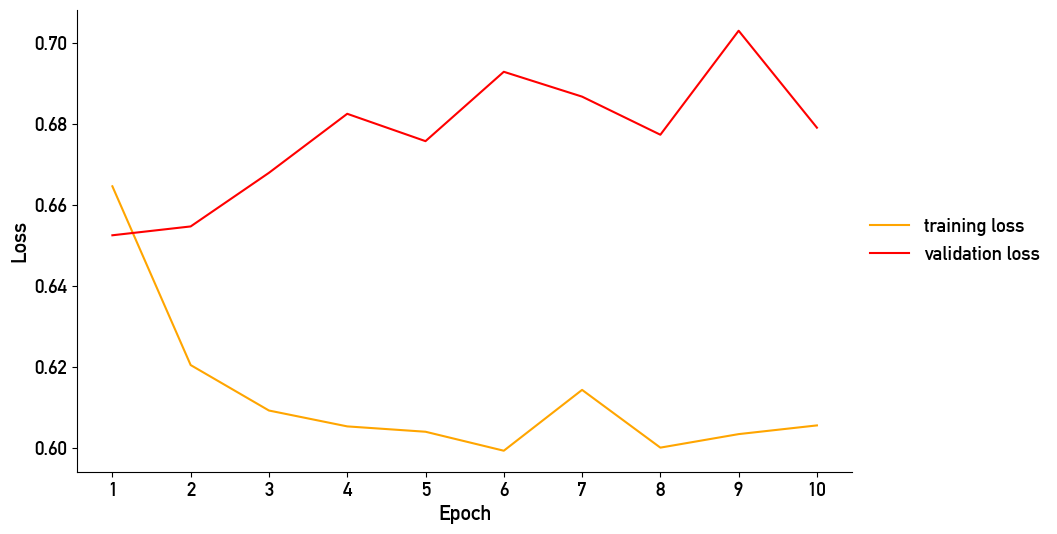

In [13]:
loss_path = os.path.join(multimodal_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

#### Accuracy metrics after training

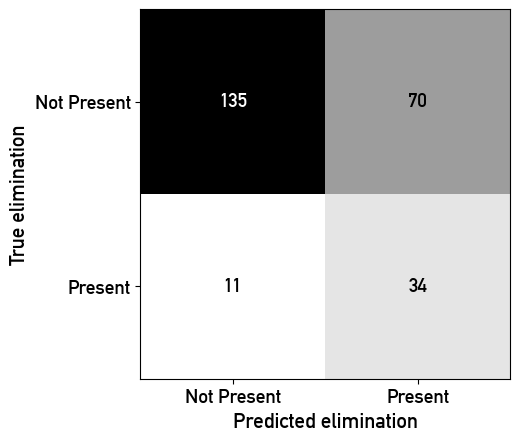

Accuracy: 0.676
Precision: 0.327
Recall: 0.756
F1 Score: 0.456


In [14]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for raster, vector, operators in test_loader:
        
        # moving the features to device
        raster = raster.to(device)
        vector = vector.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(raster, vector)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, ops="eli", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(multimodal_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

#### Saving the model

In [15]:
# save the trained model to disk
path_to_models = os.path.join(multimodal_path, "models", "elimination")

model_name = get_model_name(model, ops="eli", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

### Selection model

In [16]:
# define path to training, validation and test data for both raster and vector
path_to_raster_training_data = "../data.nosync/raster/training_data/selection/training"
path_to_vector_training_data = "../data.nosync/vector/training_data/selection/training"
path_to_raster_validation_data = "../data.nosync/raster/training_data/selection/validation"
path_to_vector_validation_data = "../data.nosync/vector/training_data/selection/validation"
path_to_raster_test_data = "../data.nosync/raster/training_data/selection/test"
path_to_vector_test_data = "../data.nosync/vector/training_data/selection/test"

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
n_classes = len(selection_operators)

batch_size = 16

# construct training DataLoader
training_set = BuildingMultimodalDataset(path_to_raster_training_data, path_to_vector_training_data, operators=selection_operators)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True, collate_fn=collate_raster_vector)

# construct validation DataLoader (no shuffling)
validation_set = BuildingMultimodalDataset(path_to_raster_validation_data, path_to_vector_validation_data, operators=selection_operators)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_raster_vector)

# construct test DataLoader (no shuffling)
test_set = BuildingMultimodalDataset(path_to_raster_test_data, path_to_vector_test_data, operators=selection_operators)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_raster_vector)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
250 samples in the validation set.
250 samples in the test set.


In [17]:
# load the trained raster model
raster_model_path = "../data.nosync/raster/models/selection"
#raster_model_name = "CNN_sel_attachRoadsTrue_8481988p_1000s_10ep_bs16.pth"
#raster_model = CNN(n_channels=3, n_classes=4)
raster_model_name = "ViT_sel_attachRoadsTrue_26844804p_1000s_10ep_bs16.pth"
raster_model = ViT(channels=3, num_classes=4)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name))
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()
    
# load the trained vector model
vector_model_path = "../data.nosync/vector/models/selection"
#vector_model_name = "HGNN_sel_attachRoadsTrue_278276p_1000s_10ep_bs16.pth"
#vector_model = initialize_gnn(model="hgnn", sample=training_set[0][1], hidden_channels=128, num_layers=2, node_to_predict="focal_building")
vector_model_name = "HGT_sel_attachRoadsTrue_662182p_1000s_10ep_bs16.pth"
vector_model = initialize_gnn(model="hgt", sample=training_set[0][1], hidden_channels=128, num_heads=2, 
                              num_layers=2, node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name))
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

print("Models successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Models successfully loaded.


In [18]:
# initialize the multimodal model
model = MultimodalModel(raster_model, 
                        vector_model, 
                        dummy_raster_sample=training_set[0][0], 
                        dummy_vector_sample=training_set[0][1], 
                        n_classes=n_classes)

model.to(device)

learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Multimodal Model with 27,481,894 parameters consisting of
        raster model with 26,811,904 parameters and 
        vector model with 628,898 parameters.


### Training loop

In [19]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (raster, vector, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        raster = raster.to(device)
        vector = vector.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(raster, vector) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for raster, vector, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            raster = raster.to(device)
            vector = vector.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(raster, vector)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="sel", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(multimodal_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.630, validation loss: 0.604
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.584, validation loss: 0.600
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.583, validation loss: 0.600
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

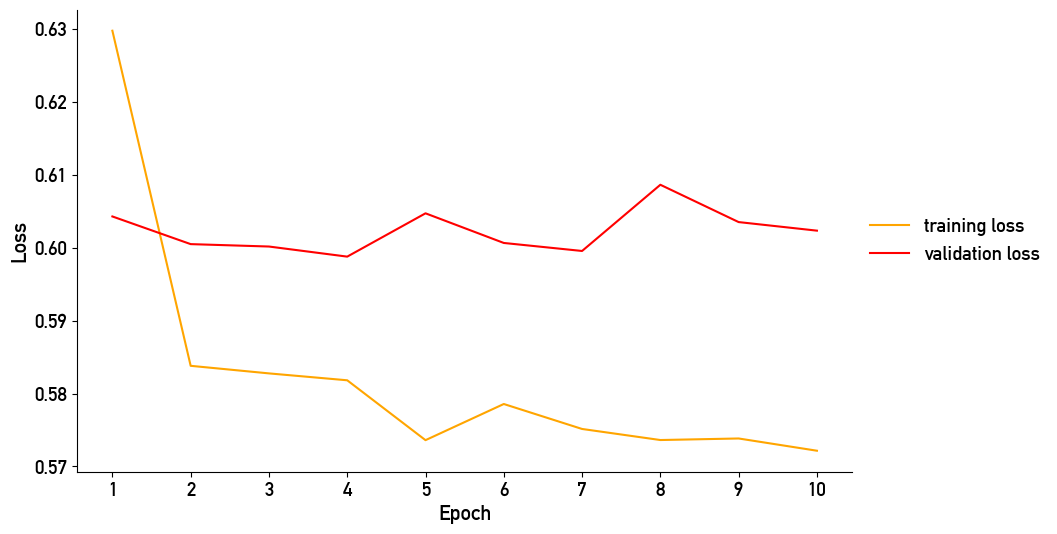

In [20]:
loss_path = os.path.join(multimodal_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

#### Accuracy metrics after training

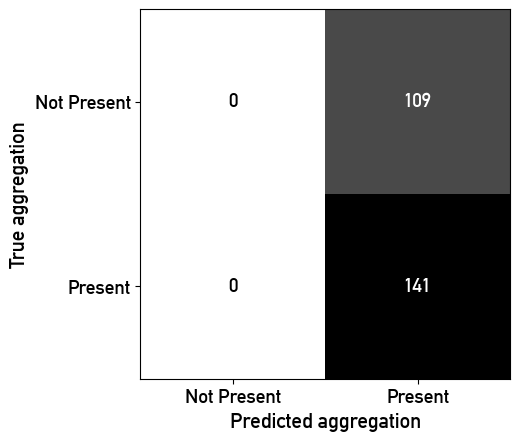

Accuracy: 0.564
Precision: 0.564
Recall: 1.000
F1 Score: 0.721


/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


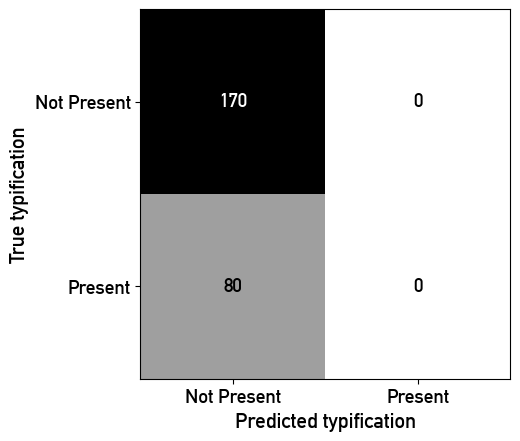

Accuracy: 0.680
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


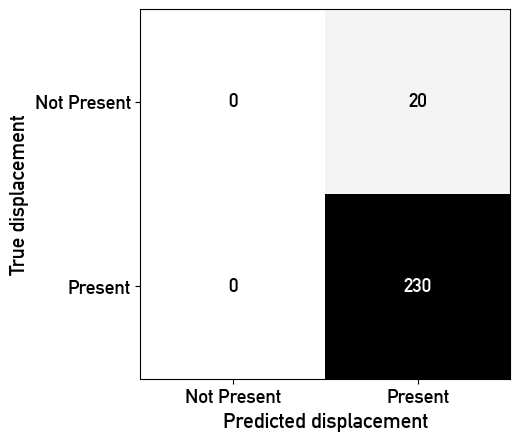

Accuracy: 0.920
Precision: 0.920
Recall: 1.000
F1 Score: 0.958


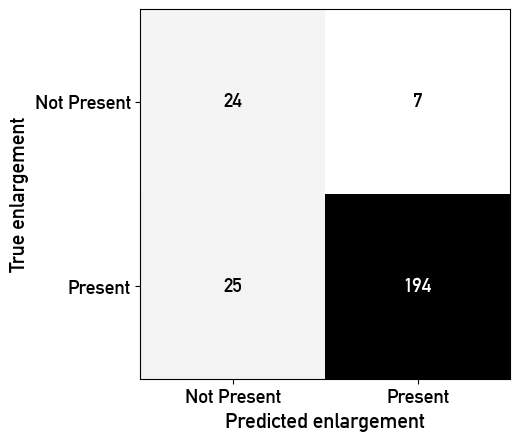

Accuracy: 0.872
Precision: 0.965
Recall: 0.886
F1 Score: 0.924


In [21]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for raster, vector, operators in test_loader:
        
        # moving the features to device
        raster = raster.to(device)
        vector = vector.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(raster, vector)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, ops="sel", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(multimodal_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

#### Saving the model

In [22]:
# save the trained model to disk
path_to_models = os.path.join(multimodal_path, "models", "selection")

model_name = get_model_name(model, ops="sel", attach_roads=True, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))